In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GRU
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os
# from keras.layers import LeakyReLU3
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.constraints import non_neg, max_norm

Using TensorFlow backend.
C:\Users\Ravindra Singh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Ravindra Singh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Ravindra Singh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Ravindra Singh\anaconda3\lib\site-packages\t

In [2]:
DATA_PATH = 'npy-files_chroma'

def get_labels(path=DATA_PATH):
    labels = os.listdir(path)
    #print(labels)
    labels_indices = np.arange(0, len(labels))
    #print(labels_indices)
    return labels, labels_indices, to_categorical(labels_indices)

def get_train_test(split_ratio=0.8, random_state=42):
    labels, indices, _ = get_labels()
#    print(labels)
#     print(indices)
    X = np.load(DATA_PATH+'/'+labels[0] )
    print(X[0].shape)
#     print(X[0])
    y = np.zeros(X.shape[0])

    for i, label in enumerate(labels[1:]):
        x = np.load(DATA_PATH+'/'+label )
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value=(i + 1)))
    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size=(1 - split_ratio), random_state=random_state)

In [3]:
OUTPUT_PATH = 'OUTPUT/'
EPOCHS = 50

CLASSES_NUM = 2

In [4]:
X_train, X_test, y_train, y_test = get_train_test()

(12, 31)


In [5]:
X_train = X_train.reshape(-1,1,12,31)

X_test = X_test.reshape(-1,1,12,31)

In [6]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(160, 1, 12, 31) (160,) (40, 1, 12, 31) (40,)


In [7]:
print(X_train.shape, X_test.shape)

(160, 1, 12, 31) (40, 1, 12, 31)


In [8]:
y_train_hot = to_categorical(y_train,num_classes=CLASSES_NUM)
y_test_hot = to_categorical(y_test,num_classes=CLASSES_NUM)

In [9]:
print(y_train_hot.shape)

(160, 2)


In [10]:
print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(160, 1, 12, 31) (160, 2) (40, 1, 12, 31) (40, 2)


In [11]:
X_test.shape

(40, 1, 12, 31)

In [12]:
X_train.shape

(160, 1, 12, 31)

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
 
model = Sequential()
 
model.add(Conv2D(20, kernel_size=(3, 3), activation='relu', padding='same',input_shape=(1, 12,31), data_format='channels_first'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same', data_format='channels_first'))
 
model.add(Conv2D(40, kernel_size=(3, 3), activation='relu',padding='same', data_format='channels_first'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same', data_format='channels_first'))

# model.add(Conv2D(40, kernel_size=(3, 3), activation='relu', padding='same',data_format='channels_first'))

# model.add(Conv2D(40, kernel_size=(3, 3), activation='relu', padding='same',data_format='channels_first'))

model.add(Flatten())
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.4))  
model.add(Dense(2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 20, 12, 31)        200       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 6, 16)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 40, 6, 16)         7240      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 40, 3, 8)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 960)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 40)                38440     
_________________________________________________________________
dropout_3 (Dropout)          (None, 40)                0         
__________

In [16]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [17]:
# from keras.optimizers import RMSprop,SGD,Adam
# from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# checkpoint = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=3,verbose=1,restore_best_weights=True)


# reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=3,verbose=1,min_delta=0.01)
# callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

In [19]:
history = model.fit(X_train, y_train_hot,batch_size=32,epochs=20,verbose=1,validation_data=(X_test, y_test_hot))

Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - ETA: 0s - loss: 0.1418 - acc: 1.000 - ETA: 0s - loss: 0.2074 - acc: 0.937 - 0s 1ms/step - loss: 0.1954 - acc: 0.9437 - val_loss: 0.2278 - val_acc: 0.9500
Epoch 2/20
160/160 [==============================] - ETA: 0s - loss: 0.1969 - acc: 0.968 - ETA: 0s - loss: 0.1859 - acc: 0.968 - 0s 924us/step - loss: 0.1815 - acc: 0.9688 - val_loss: 0.2199 - val_acc: 0.9500
Epoch 3/20
160/160 [==============================] - ETA: 0s - loss: 0.2371 - acc: 0.906 - ETA: 0s - loss: 0.1867 - acc: 0.960 - 0s 855us/step - loss: 0.1803 - acc: 0.9562 - val_loss: 0.1588 - val_acc: 1.0000
Epoch 4/20
160/160 [==============================] - ETA: 0s - loss: 0.1142 - acc: 0.968 - ETA: 0s - loss: 0.1221 - acc: 0.989 - 0s 853us/step - loss: 0.1301 - acc: 0.9875 - val_loss: 0.1510 - val_acc: 1.0000
Epoch 5/20
160/160 [==============================] - ETA: 0s - loss: 0.1341 - acc: 0.968 - ETA: 0s - loss: 0.1077 - 

In [31]:
model.save("Chorma_npy.h5")

In [20]:
test_acc = model.evaluate(X_test, y_test_hot)
test_acc

40/40 [==============================] - ETA:  - 0s 534us/step


[0.01030592992901802, 1.0]

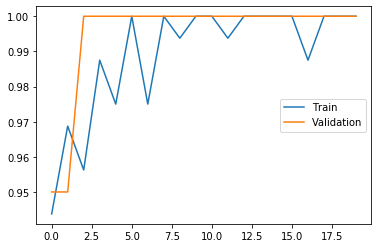

In [21]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

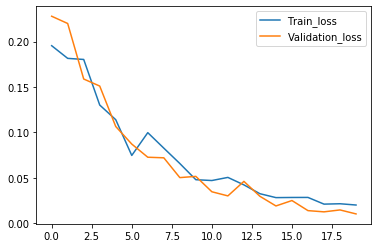

In [22]:
plt.plot(history.history['loss'], label="train_loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend(['Train_loss', 'Validation_loss'], loc='upper right')
plt.show()

In [23]:
np.set_printoptions(threshold=np.inf)
np.set_printoptions(suppress=True)
preds=model.predict(X_test)

In [24]:
preds=model.predict(X_test)
preds

array([[0.9944502 , 0.00554984],
       [0.9844757 , 0.01552429],
       [0.99905914, 0.00094083],
       [0.04790414, 0.95209587],
       [0.04790414, 0.95209587],
       [0.00312623, 0.99687374],
       [0.99960536, 0.00039461],
       [0.00365134, 0.9963486 ],
       [0.00365134, 0.9963486 ],
       [0.9985777 , 0.00142231],
       [0.98547155, 0.01452838],
       [0.00026506, 0.99973494],
       [0.00009266, 0.9999074 ],
       [0.9965695 , 0.00343044],
       [0.00008269, 0.99991727],
       [0.02742188, 0.9725781 ],
       [0.99528015, 0.0047199 ],
       [0.00824321, 0.9917568 ],
       [0.99056375, 0.00943626],
       [0.99960536, 0.00039461],
       [0.00270974, 0.99729025],
       [0.9844757 , 0.01552429],
       [0.00002734, 0.9999727 ],
       [0.9944502 , 0.00554984],
       [0.98547155, 0.01452838],
       [0.9876889 , 0.01231101],
       [0.99056375, 0.00943626],
       [0.98547155, 0.01452838],
       [0.00270974, 0.99729025],
       [0.04102521, 0.9589748 ],
       [0.

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
cf=confusion_matrix(y_test_hot.argmax(axis=1), preds.argmax(axis=1))

Confusion Matrix


In [26]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45,fontsize=16)
        plt.yticks(tick_marks, target_names,fontsize=16)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),fontsize=16,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),fontsize=16,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


Classification Report:
              precision    recall  f1-score   support

        Ravi       1.00      1.00      1.00        21
      Sachin       1.00      1.00      1.00        19

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



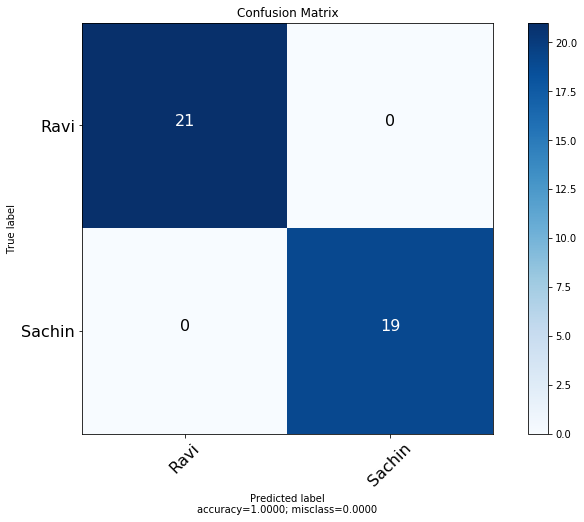

In [27]:
# Create classification report
class_report = classification_report(y_test_hot.argmax(axis=1), preds.argmax(axis=1),
                                     target_names = ['Ravi','Sachin'])
print("\nClassification Report:")
print(class_report)

# plot the confusion matrix
plot_confusion_matrix(cm           = cf, 
                      normalize    = False,
                      target_names = ['Ravi','Sachin'],title        = "Confusion Matrix")

In [28]:
X_train = X_train.reshape(len(X_train), 1, 12,31)   #X_train = np.expand_dims(X_train, axis=1)
preds = model.predict(X_train)
from sklearn.metrics import classification_report, confusion_matrix
print('confusion_matrix')
confusion_matrix(y_train_hot.argmax(axis=1), preds.argmax(axis=1))

confusion_matrix


array([[79,  0],
       [ 0, 81]], dtype=int64)

In [29]:
X_test = X_test.reshape(len(X_test), 1,12,31)  #X_test = np.expand_dims(X_test, axis=1)
preds = model.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print('confusion_matrix')
confusion_matrix(y_test_hot.argmax(axis=1), preds.argmax(axis=1))

confusion_matrix


array([[21,  0],
       [ 0, 19]], dtype=int64)

In [30]:
input_data = X_test
print("Input data shape:", input_data.shape)
print("First input example:", input_data[0])

Input data shape: (40, 1, 12, 31)
First input example: [[[0.08426502 0.11080505 0.06369986 0.06883395 0.08406475 0.09695263
   0.11582932 0.08586617 0.11972329 0.09273967 0.10333083 0.10831839
   0.10427572 0.06783593 0.10588245 0.10324989 0.07019125 0.0333855
   0.03799182 0.03672206 0.03275577 0.02997842 0.04553708 0.03759224
   0.04881991 0.04990774 0.03749206 0.05616381 0.04871055 0.04064694
   0.05667999]
  [0.05367251 0.07683702 0.05577316 0.06585202 0.04461719 0.04656969
   0.0943911  0.06503841 0.0930761  0.0749786  0.08479505 0.07884565
   0.06459515 0.09461005 0.06256664 0.05783572 0.0803907  0.0624525
   0.04510292 0.04691824 0.04428668 0.03508742 0.05387924 0.04640929
   0.07226734 0.05681643 0.03806297 0.08128217 0.06968126 0.03832466
   0.08890948]
  [0.23551602 0.25958202 0.09731492 0.05164533 0.08224765 0.06214486
   0.08169565 0.08337004 0.07342411 0.0546912  0.06980975 0.07338566
   0.12825227 0.12591119 0.10551187 0.11754038 0.07244647 0.04837925
   0.03503829 0.0409

# load the model

In [1]:
model = keras.models.load_model('Chorma_npy.h5')
model.summary()

NameError: name 'keras' is not defined

In [5]:
from sklearn.preprocessing import LabelEncoder
# Function to extract chroma features from a single audio file
def extract_chroma_features_from_file(file_path):
    y, sr = librosa.load(file_path, sr=8000)
    # Ensure the chroma feature matrix has 31 frames
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=12, n_fft=2048, hop_length=512)
    chroma = chroma[:, :31]  # Truncate or pad to 31 frames if necessary
    if chroma.shape[1] < 31:
        padding = np.zeros((12, 31 - chroma.shape[1]))
        chroma = np.hstack((chroma, padding))
    return chroma

# Example file path
# file_path = r"D:\Command + Non_Command_words\hardware_data_NCM\data-hw\Ravi_boy_4.wav"
file_path = r"D:\Command + Non_Command_words\Training_dataset\Bank\sachin_bank_7.wav"

# Extract features from the file
features = extract_chroma_features_from_file(file_path)

# Reshape features to match the input shape expected by the model
features = features.reshape(1, 1, 12, 31)  # Add batch size and channel dimensions

# Make the prediction
prediction = model.predict(features)
predicted_class = np.argmax(prediction, axis=1)

# Decode the predicted class
le = LabelEncoder()
le.fit(['Ravi', 'Sachin'])
predicted_label = le.inverse_transform(predicted_class)

print(f"The predicted class for the audio file is: {predicted_label[0]}")



The predicted class for the audio file is: Ravi
